In [2]:
# 1. Calculate the accuracy of each model

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sqlite3

In [12]:
def load_db(db_path, MODEL_NAME):
    # load the db
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # get the data
    cursor.execute("SELECT * FROM answers WHERE LLM_name = ?", (MODEL_NAME,))
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=[col[0] for col in cursor.description])
    
    # change the Class to int
    df['Class'] = df['Class'].astype(int)
    df['LLM_output_with_tree_class'] = df['LLM_output_with_tree_class'].astype(int)
    df['LLM_output_without_tree_class'] = df['LLM_output_without_tree_class'].astype(int)
    df['Include_memory'] = df['Include_memory'].astype(int)
    df['Include_description'] = df['Include_description'].astype(int)
    df['Include_zero_shot_label'] = df['Include_zero_shot_label'].astype(int)

    return cursor, conn, df

In [4]:
def add_is_correct_col(df):
    # add column tree_is_correct (int(Class) == int(LLM_output_with_tree_class))
    df['tree_is_correct'] = (df['Class'] == df['LLM_output_with_tree_class']).astype(int)
    df['without_tree_is_correct'] = (df['Class'] == df['LLM_output_without_tree_class']).astype(int)
    print(df[['Class', 'LLM_output_without_tree_class', 'without_tree_is_correct' ]])
    return df

In [5]:
def plot_comparison_accuracy(df):
    df['tree_is_correct'] = df['tree_is_correct'].astype(int)
    df['without_tree_is_correct'] = df['without_tree_is_correct'].astype(int)

    # Group by class and calculate mean accuracy
    tree_is_correct = df.groupby('Class')['tree_is_correct'].mean()
    without_tree_is_correct = df.groupby('Class')['without_tree_is_correct'].mean()

    # Sort by class index
    tree_is_correct = tree_is_correct.sort_index()
    without_tree_is_correct = without_tree_is_correct.sort_index()

    # Bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.4
    opacity = 0.8

    # Increase space between columns by adjusting the index
    index = np.arange(len(tree_is_correct)) * 1.5  # Multiply by a factor to increase spacing

    # Plot bars
    rects1 = plt.bar(index, tree_is_correct, bar_width, alpha=opacity, color='b', label='With tree')
    rects2 = plt.bar(index + bar_width, without_tree_is_correct, bar_width, alpha=opacity, color='r', label='Without tree')

    # Customize the plot
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Class')
    plt.xticks(index + bar_width / 2, tree_is_correct.index, rotation=90)  # Center ticks between bars
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    return tree_is_correct, without_tree_is_correct

In [6]:
def accuracy_comparison_grouped(tree_is_correct, without_tree_is_correct):
    # get the classes where the difference in accuracy is greater than or equal 0.4
    tree_diff = tree_is_correct - without_tree_is_correct
    tree_diff = tree_diff[tree_diff >= 0.4]
    # sort by value
    tree_diff = tree_diff.sort_values(ascending=False)
    for i in tree_diff.index:
        print(f'Class {i} with tree outperform without tree by {tree_diff[i]*100}%')

    print('----------------------')
    # get the classes where the difference in accuracy is greater than or equal 0.4
    without_tree_diff = without_tree_is_correct - tree_is_correct
    without_tree_diff = without_tree_diff[without_tree_diff >= 0.4]
    # sort by value
    without_tree_diff = without_tree_diff.sort_values(ascending=False)
    # mean accuracy of each model
    print("Mean accuracy of model with tree: ", tree_is_correct.mean())
    print("Mean accuracy of model without tree: ", without_tree_is_correct.mean())
    print('----------------------')
    for i in without_tree_diff.index:
        print(f'Class {i} without tree outperform with tree model by {without_tree_diff[i]*100}%')
    

In [7]:
from matplotlib_venn import venn2
def plot_venn_comparison(df):
      # rows where both models are correct
      both_correct = df[(df['tree_is_correct'] == 1) & (df['without_tree_is_correct'] == 1)]

      # rows where both models are incorrect
      both_incorrect = df[(df['tree_is_correct'] == 0) & (df['without_tree_is_correct'] == 0)]

      # rows where tree model is correct and the other is incorrect
      tree_is_correct_only = df[((df['tree_is_correct'] == 1) & (df['without_tree_is_correct'] == 0))]

      # rows where without tree model is correct and the other is incorrect
      without_tree_is_correct_only = df[((df['tree_is_correct'] == 0) & (df['without_tree_is_correct'] == 1))]

      # Create the Venn diagram
      venn2(subsets=(len(tree_is_correct_only), len(without_tree_is_correct_only), len(both_correct)),
            set_labels=('With Tree', 'Without Tree'))


      print("Number of samples where both models are correct: ", len(both_correct))
      print("Number of samples where both models are incorrect: ", len(both_incorrect))
      print("Number of samples where tree model is correct and the other is incorrect: ", len(tree_is_correct_only))
      print("Number of samples where without tree model is correct and the other is incorrect: ", len(without_tree_is_correct_only))

In [8]:
def calculate_incorrectness(df):
    # rows where tree model is correct and the other is incorrect
    tree_is_incorrect_only = df[((df['tree_is_correct'] == 0) & (df['without_tree_is_correct'] == 1))]

    # rows where without tree model is correct and the other is incorrect
    without_tree_is_incorrect_only = df[((df['tree_is_correct'] == 1) & (df['without_tree_is_correct'] == 0))]

    return tree_is_incorrect_only, without_tree_is_incorrect_only

In [9]:
def incorrect_per_class(df):
    # Total, both correct, both incorrect, tree correct only, without tree correct only, tree incorrect only, without tree incorrect only
    class_to_perc_incorrect_withouttree = {}
    class_to_perc_incorrect_tree = {}
    
    number_of_classes = df['Class'].nunique()
    for class_ in range(number_of_classes):
        class_pred = df[df['Class'] == class_]
        total = len(class_pred)
        both_correct = len(class_pred[(class_pred['tree_is_correct'] == 1) & (class_pred['without_tree_is_correct'] == 1)])
        both_incorrect = len(class_pred[(class_pred['tree_is_correct'] == 0) & (class_pred['without_tree_is_correct'] == 0)])
        tree_correct_only = len(class_pred[(class_pred['tree_is_correct'] == 1) & (class_pred['without_tree_is_correct'] == 0)])
        without_tree_correct_only = len(class_pred[(class_pred['tree_is_correct'] == 0) & (class_pred['without_tree_is_correct'] == 1)])
        tree_incorrect_only = len(class_pred[(class_pred['tree_is_correct'] == 0) & (class_pred['without_tree_is_correct'] == 1)])
        without_tree_incorrect_only = len(class_pred[(class_pred['tree_is_correct'] == 1) & (class_pred['without_tree_is_correct'] == 0)])

        print(f"Class {class_}:")
        print(f"Total: {total}")
        print(f"Both correct: {both_correct}")
        print(f"Both incorrect: {both_incorrect}")
        print(f"Tree correct only: {tree_correct_only}")
        print(f"Without tree correct only: {without_tree_correct_only}")
        print(f"Tree incorrect only: {tree_incorrect_only}")
        print(f"Without tree incorrect only: {without_tree_incorrect_only}")
        print("\n")

        # print("Tree only percentage of incorrect samples", tree_incorrect_only / total)
        # print("Without tree only percentage of incorrect samples", without_tree_incorrect_only / total)
        class_to_perc_incorrect_tree[class_] = tree_incorrect_only / total
        class_to_perc_incorrect_withouttree[class_] = without_tree_incorrect_only / total

    # sort by values
    class_to_perc_incorrect_tree = dict(sorted(class_to_perc_incorrect_tree.items(), key=lambda item: item[1]))
    class_to_perc_incorrect_withouttree = dict(sorted(class_to_perc_incorrect_withouttree.items(), key=lambda item: item[1]))

    return class_to_perc_incorrect_tree, class_to_perc_incorrect_withouttree


In [10]:
def plot_class_accuracy(df):
    """
    Plot sorted bar chart showing accuracy for each class.
    
    Parameters:
    df: pandas DataFrame with columns 'Class', 'tree_is_correct', 'without_tree_is_correct'
    
    Returns:
    tuple: (class_to_accuracy_tree, class_to_accuracy_withouttree) dictionaries
    """
    class_to_accuracy_tree = {}
    class_to_accuracy_withouttree = {}
    
    number_of_classes = df['Class'].nunique()
    
    # Calculate accuracy for each class
    for class_ in range(number_of_classes):
        class_pred = df[df['Class'] == class_]
        total = len(class_pred)
        
        if total > 0:  # Avoid division by zero
            tree_correct = len(class_pred[class_pred['tree_is_correct'] == 1])
            without_tree_correct = len(class_pred[class_pred['without_tree_is_correct'] == 1])
            
            class_to_accuracy_tree[class_] = tree_correct / total
            class_to_accuracy_withouttree[class_] = without_tree_correct / total
        else:
            class_to_accuracy_tree[class_] = 0
            class_to_accuracy_withouttree[class_] = 0
    
    # Sort by tree accuracy (you can change this to sort by without_tree accuracy if preferred)
    sorted_classes = sorted(class_to_accuracy_tree.keys(), key=lambda x: class_to_accuracy_tree[x])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.35
    opacity = 0.8
    
    # Create positions for bars
    x_pos = np.arange(len(sorted_classes))
    
    # Get sorted accuracy values
    tree_accuracies = [class_to_accuracy_tree[class_] for class_ in sorted_classes]
    withouttree_accuracies = [class_to_accuracy_withouttree[class_] for class_ in sorted_classes]
    
    # Create bars
    bars1 = ax.bar(x_pos - bar_width/2, tree_accuracies, bar_width, 
                   alpha=opacity, color='skyblue', label='With Tree', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x_pos + bar_width/2, withouttree_accuracies, bar_width,
                   alpha=opacity, color='lightcoral', label='Without Tree', edgecolor='black', linewidth=0.5)
    
    # Customize the plot
    ax.set_xlabel('Class ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Class Accuracy Comparison (Sorted by Tree Accuracy)', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'Class {class_}' for class_ in sorted_classes], rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Set y-axis limits
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    return class_to_accuracy_tree, class_to_accuracy_withouttree

# Alternative function for single model accuracy plot
def plot_single_model_accuracy(df, model_type='tree'):
    """
    Plot sorted bar chart for a single model's accuracy across classes.
    
    Parameters:
    df: pandas DataFrame with columns 'Class', 'tree_is_correct', 'without_tree_is_correct'
    model_type: str, either 'tree' or 'without_tree'
    """
    class_to_accuracy = {}
    
    # Choose the correct column based on model type
    correct_col = 'tree_is_correct' if model_type == 'tree' else 'without_tree_is_correct'
    
    number_of_classes = df['Class'].nunique()
    
    # Calculate accuracy for each class
    for class_ in range(number_of_classes):
        class_pred = df[df['Class'] == class_]
        total = len(class_pred)
        
        if total > 0:
            correct = len(class_pred[class_pred[correct_col] == 1])
            class_to_accuracy[class_] = correct / total
        else:
            class_to_accuracy[class_] = 0
    
    # Sort by accuracy
    sorted_items = sorted(class_to_accuracy.items(), key=lambda x: x[1])
    classes, accuracies = zip(*sorted_items)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create bars with gradient color based on accuracy
    colors = plt.cm.RdYlGn([acc for acc in accuracies])  # Red to Green gradient
    bars = ax.bar(range(len(classes)), accuracies, color=colors, edgecolor='black', linewidth=0.5)
    
    # Customize the plot
    ax.set_xlabel('Class ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(f'Class Accuracy - {model_type.replace("_", " ").title()} Model (Sorted)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels([f'Class {class_}' for class_ in classes], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(bar.get_x() + bar.get_width()/2., acc + 0.01,
               f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return class_to_accuracy


GTSRB GPT-4o

In [ ]:
MODEL_NAME = 'gpt-4o'
cursor, conn, gpt_df = load_db('Results/db/answers.db', MODEL_NAME)
gpt_df

,Class,Sequence,Image_path,LLM_name,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,00000,Data/GTSRB/all_sequences_training\00000\00000_...,gpt-4o,The number is '20'.,0,0,0
1,0,00001,Data/GTSRB/all_sequences_training\00000\00001_...,gpt-4o,"The number is ""20"".",0,0,0
2,0,00002,Data/GTSRB/all_sequences_training\00000\00002_...,gpt-4o,The number is 50.,1,2,1
3,0,00003,Data/GTSRB/all_sequences_training\00000\00003_...,gpt-4o,The number is '20'.,0,0,0
4,0,00004,Data/GTSRB/all_sequences_training\00000\00004_...,gpt-4o,The number is 20.,0,0,0
...,...,...,...,...,...,...,...,...
896,31,00005,Data/GTSRB/all_sequences_training\00031\00005_...,gpt-4o,"[{""question"": ""What's the sign's primary shape...",31,-1,31
897,31,00008,Data/GTSRB/all_sequences_training\00031\00008_...,gpt-4o,"[{""question"": ""What's the sign's primary shape...",31,22,31
898,31,00009,Data/GTSRB/all_sequences_training\00031\00009_...,gpt-4o,"[{""question"": ""What's the sign's primary shape...",31,-1,31
899,31,00014,Data/GTSRB/all_sequences_training\00031\00014_...,gpt-4o,"[{""question"": ""What's the sign's primary shape...",31,31,31


Replace the modified rows with the new rows with new tree structure.

In [10]:
modified_classes = ['00009', '00010', '00015', '00016', '00017', '00035', '00036', '00037', '00027', '00028']
model_updated = 'gpt-4o-15-3'
cursor.execute(f"SELECT * FROM answers WHERE LLM_name = ? AND Class IN ({','.join(['?']*len(modified_classes))})", (model_updated, *modified_classes))
rows = cursor.fetchall()
df_updated = pd.DataFrame(rows, columns=['Class', 'Sequence', 'Image_path', 'LLM_name', 'LLM_output_with_tree', 'LLM_output_without_tree', 'LLM_output_with_tree_class', 'LLM_output_without_tree_class'])

gpt_df = gpt_df.append(df_updated)
# change Class to int
gpt_df['Class'] = gpt_df['Class'].astype(int)
gpt_df['LLM_output_with_tree_class'] = gpt_df['LLM_output_with_tree_class'].astype(int)
gpt_df['LLM_output_without_tree_class'] = gpt_df['LLM_output_without_tree_class'].astype(int)

In [11]:
modified_classes = [9, 10, 15, 16, 17, 35, 36, 37, 27, 28]
# remove the rows with modified classes and LLM_name = 'gpt-4o'
print('rows before deletion: ', len(gpt_df))
gpt_df = gpt_df[~(gpt_df['Class'].isin(modified_classes) & (gpt_df['LLM_name'] == MODEL_NAME))]
print('rows after deletion: ', len(gpt_df))

rows before deletion:  1087
rows after deletion:  901


In [12]:
gpt_df

,Class,Sequence,Image_path,LLM_name,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,00000,Data/GTSRB/all_sequences_training\00000\00000_...,gpt-4o,The number is '20'.,0,0,0
1,0,00001,Data/GTSRB/all_sequences_training\00000\00001_...,gpt-4o,"The number is ""20"".",0,0,0
2,0,00002,Data/GTSRB/all_sequences_training\00000\00002_...,gpt-4o,The number is 50.,1,2,1
3,0,00003,Data/GTSRB/all_sequences_training\00000\00003_...,gpt-4o,The number is '20'.,0,0,0
4,0,00004,Data/GTSRB/all_sequences_training\00000\00004_...,gpt-4o,The number is 20.,0,0,0
...,...,...,...,...,...,...,...,...
181,28,00007,Data/GTSRB/all_sequences_training\00028\00007_...,gpt-4o-15-3,"[{""question"": ""What's the sign's primary shape...",28,28,28
182,28,00008,Data/GTSRB/all_sequences_training\00028\00008_...,gpt-4o-15-3,"[{""question"": ""What's the sign's primary shape...",28,28,28
183,28,00009,Data/GTSRB/all_sequences_training\00028\00009_...,gpt-4o-15-3,"[{""question"": ""What's the sign's primary shape...",28,-1,28
184,28,00010,Data/GTSRB/all_sequences_training\00028\00010_...,gpt-4o-15-3,"[{""question"": ""What's the sign's primary shape...",28,28,28


In [13]:
gpt_df = add_is_correct_col(gpt_df)

     Class  LLM_output_without_tree_class  without_tree_is_correct
0        0                              0                        1
1        0                              0                        1
2        0                              1                        0
3        0                              0                        1
4        0                              0                        1
..     ...                            ...                      ...
181     28                             28                        1
182     28                             28                        1
183     28                             28                        1
184     28                             28                        1
185     28                             28                        1

[901 rows x 3 columns]


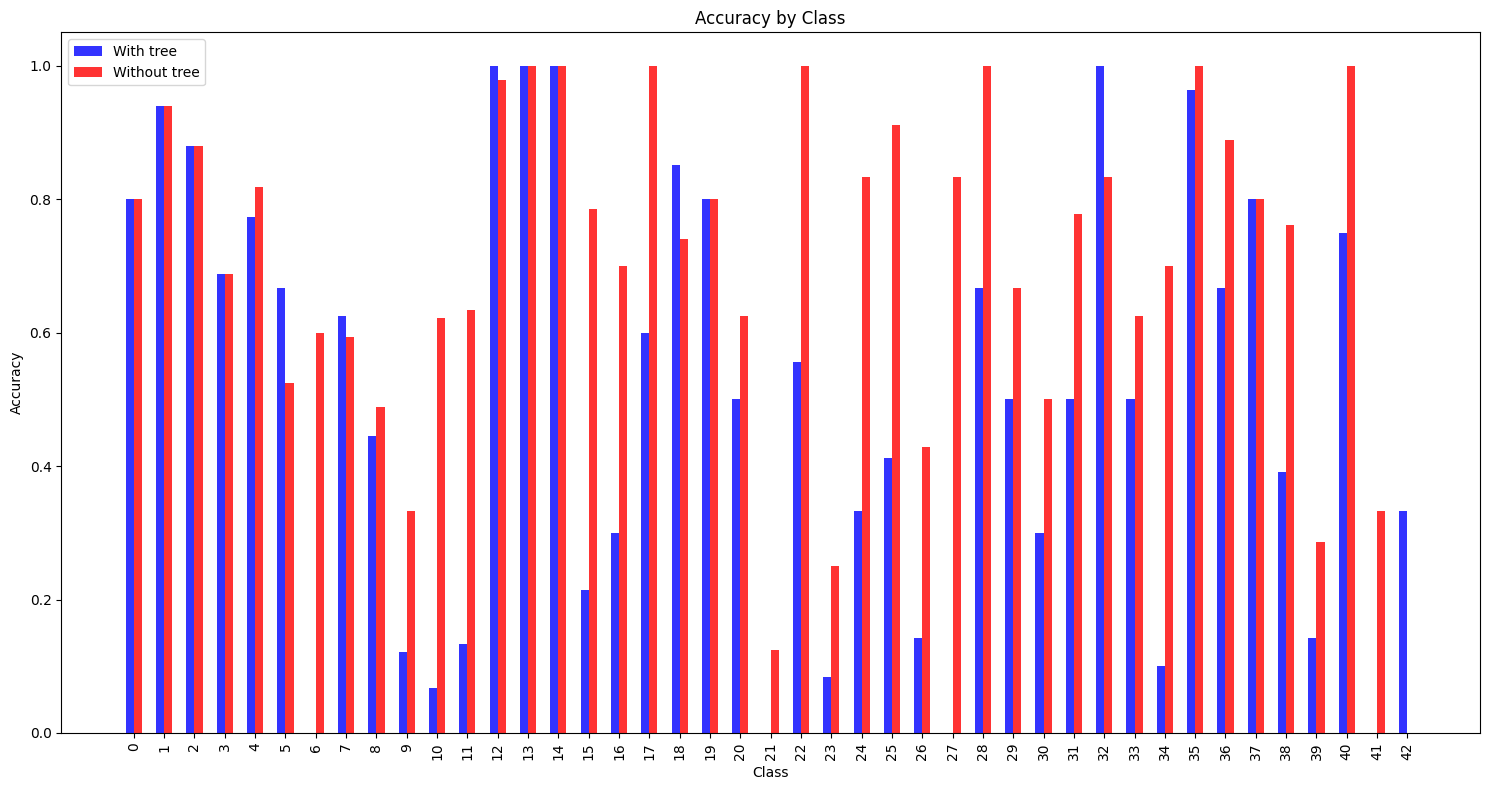

In [16]:
tree_is_correct, without_tree_is_correct = plot_comparison_accuracy(gpt_df)

In [17]:
accuracy_comparison_grouped(tree_is_correct, without_tree_is_correct)

----------------------
Mean accuracy of model with tree:  0.5010307735456428
Mean accuracy of model without tree:  0.7001112605239904
Class 27 without tree outperform with tree model by 83.33333333333334%
Class 6 without tree outperform with tree model by 60.0%
Class 34 without tree outperform with tree model by 60.0%
Class 15 without tree outperform with tree model by 57.14285714285714%
Class 10 without tree outperform with tree model by 55.55555555555556%
Class 11 without tree outperform with tree model by 50.0%
Class 24 without tree outperform with tree model by 50.0%
Class 25 without tree outperform with tree model by 50.0%
Class 22 without tree outperform with tree model by 44.44444444444444%
Class 17 without tree outperform with tree model by 40.0%


Number of samples where both models are correct:  487
Number of samples where both models are incorrect:  201
Number of samples where tree model is correct and the other is incorrect:  33
Number of samples where without tree model is correct and the other is incorrect:  180


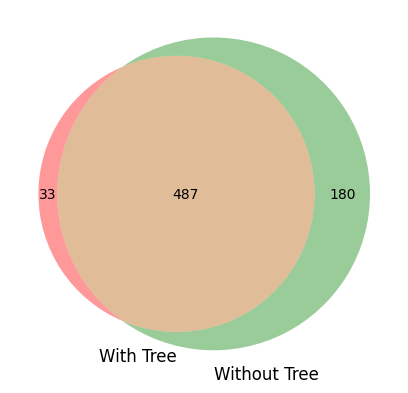

In [18]:
plot_venn_comparison(gpt_df)

Class 0:
Total: 5
Both correct: 4
Both incorrect: 1
Tree correct only: 0
Without tree correct only: 0
Tree incorrect only: 0
Without tree incorrect only: 0


Class 1:
Total: 50
Both correct: 46
Both incorrect: 2
Tree correct only: 1
Without tree correct only: 1
Tree incorrect only: 1
Without tree incorrect only: 1


Class 2:
Total: 50
Both correct: 41
Both incorrect: 3
Tree correct only: 3
Without tree correct only: 3
Tree incorrect only: 3
Without tree incorrect only: 3


Class 3:
Total: 32
Both correct: 20
Both incorrect: 8
Tree correct only: 2
Without tree correct only: 2
Tree incorrect only: 2
Without tree incorrect only: 2


Class 4:
Total: 44
Both correct: 34
Both incorrect: 8
Tree correct only: 0
Without tree correct only: 2
Tree incorrect only: 2
Without tree incorrect only: 0


Class 5:
Total: 42
Both correct: 21
Both incorrect: 13
Tree correct only: 7
Without tree correct only: 1
Tree incorrect only: 1
Without tree incorrect only: 7


Class 6:
Total: 10
Both correct: 0
Both i

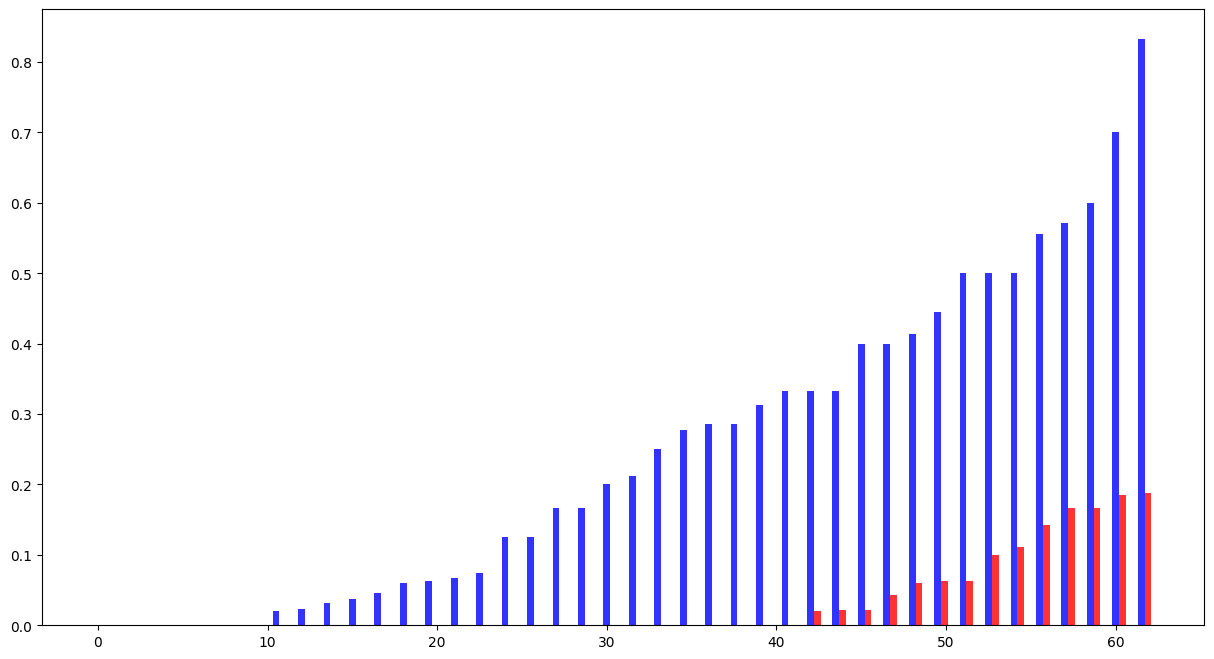

In [19]:
class_to_perc_incorrect_tree, class_to_perc_incorrect_withouttree = incorrect_per_class(gpt_df)

In [20]:
class_to_perc_incorrect_tree

{0: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 19: 0.0,
 32: 0.0,
 37: 0.0,
 1: 0.02,
 5: 0.023809523809523808,
 7: 0.03125,
 35: 0.037037037037037035,
 4: 0.045454545454545456,
 2: 0.06,
 3: 0.0625,
 8: 0.06666666666666667,
 18: 0.07407407407407407,
 20: 0.125,
 21: 0.125,
 23: 0.16666666666666666,
 29: 0.16666666666666666,
 30: 0.2,
 9: 0.21212121212121213,
 40: 0.25,
 31: 0.2777777777777778,
 26: 0.2857142857142857,
 39: 0.2857142857142857,
 33: 0.3125,
 28: 0.3333333333333333,
 36: 0.3333333333333333,
 41: 0.3333333333333333,
 16: 0.4,
 17: 0.4,
 38: 0.41304347826086957,
 22: 0.4444444444444444,
 11: 0.5,
 24: 0.5,
 25: 0.5,
 10: 0.5555555555555556,
 15: 0.5714285714285714,
 6: 0.6,
 34: 0.7,
 27: 0.8333333333333334}

LLAMA

In [36]:
MODEL_LLAMA = 'llama-3.2-11b-vision-preview'
cursor, conn, llama_df = load_db('Results/db/answers.db', MODEL_LLAMA)
llama_df

,Class,Sequence,Image_path,LLM_name,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,00000,Data/GTSRB/all_sequences_training\00000\00000_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",2,0,2
1,0,00001,Data/GTSRB/all_sequences_training\00000\00001_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",4,0,4
2,0,00002,Data/GTSRB/all_sequences_training\00000\00002_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",4,32,4
3,0,00003,Data/GTSRB/all_sequences_training\00000\00003_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",32,0,32
4,0,00004,Data/GTSRB/all_sequences_training\00000\00004_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",42,0,42
...,...,...,...,...,...,...,...,...
896,42,00001,Data/GTSRB/all_sequences_training\00042\00001_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",24,41,24
897,42,00002,Data/GTSRB/all_sequences_training\00042\00002_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",5,-1,5
898,42,00003,Data/GTSRB/all_sequences_training\00042\00003_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",41,-1,41
899,42,00004,Data/GTSRB/all_sequences_training\00042\00004_...,llama-3.2-11b-vision-preview,"[{""question"": ""What's the sign's primary shape...",43,32,-1


In [37]:
llama_df = add_is_correct_col(llama_df)

     Class  LLM_output_without_tree_class  without_tree_is_correct
0        0                              0                        1
1        0                              0                        1
2        0                              1                        0
3        0                              0                        1
4        0                              0                        1
..     ...                            ...                      ...
181     28                             28                        1
182     28                             28                        1
183     28                             28                        1
184     28                             28                        1
185     28                             28                        1

[901 rows x 3 columns]


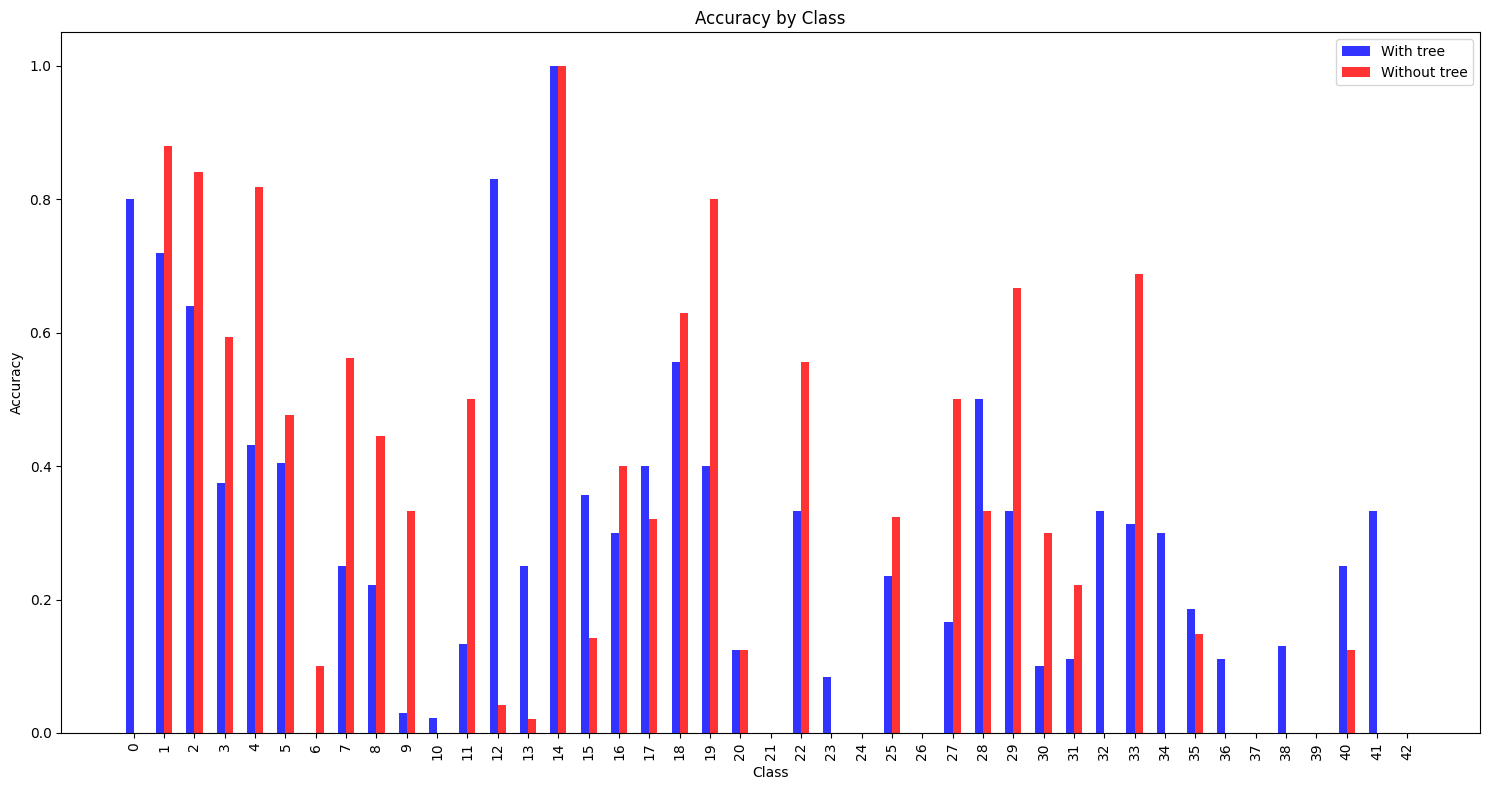

In [39]:
tree_is_correct_llama, without_tree_is_correct_llama = plot_comparison_accuracy(llama_df)

In [40]:
accuracy_comparison_grouped(tree_is_correct_llama, without_tree_is_correct_llama)

Class 0 with tree outperform without tree by 80.0%
Class 12 with tree outperform without tree by 78.72340425531915%
----------------------
Mean accuracy of model with tree:  0.28060735307903156
Mean accuracy of model without tree:  0.2997960164453528
Class 19 without tree outperform with tree model by 40.0%


Number of samples where both models are correct:  192
Number of samples where both models are incorrect:  461
Number of samples where tree model is correct and the other is incorrect:  107
Number of samples where without tree model is correct and the other is incorrect:  141


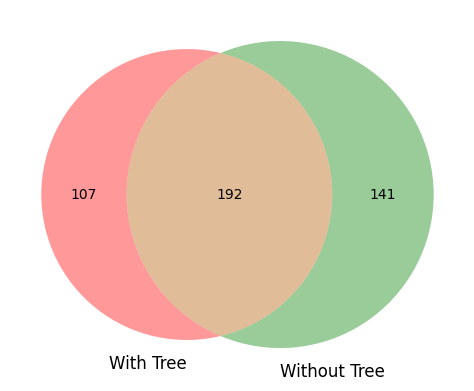

In [41]:
plot_venn_comparison(llama_df)

Class 0:
Total: 5
Both correct: 0
Both incorrect: 1
Tree correct only: 4
Without tree correct only: 0
Tree incorrect only: 0
Without tree incorrect only: 4


Class 1:
Total: 50
Both correct: 36
Both incorrect: 6
Tree correct only: 0
Without tree correct only: 8
Tree incorrect only: 8
Without tree incorrect only: 0


Class 2:
Total: 50
Both correct: 30
Both incorrect: 6
Tree correct only: 2
Without tree correct only: 12
Tree incorrect only: 12
Without tree incorrect only: 2


Class 3:
Total: 32
Both correct: 10
Both incorrect: 11
Tree correct only: 2
Without tree correct only: 9
Tree incorrect only: 9
Without tree incorrect only: 2


Class 4:
Total: 44
Both correct: 18
Both incorrect: 7
Tree correct only: 1
Without tree correct only: 18
Tree incorrect only: 18
Without tree incorrect only: 1


Class 5:
Total: 42
Both correct: 15
Both incorrect: 20
Tree correct only: 2
Without tree correct only: 5
Tree incorrect only: 5
Without tree incorrect only: 2


Class 6:
Total: 10
Both correct: 0
B

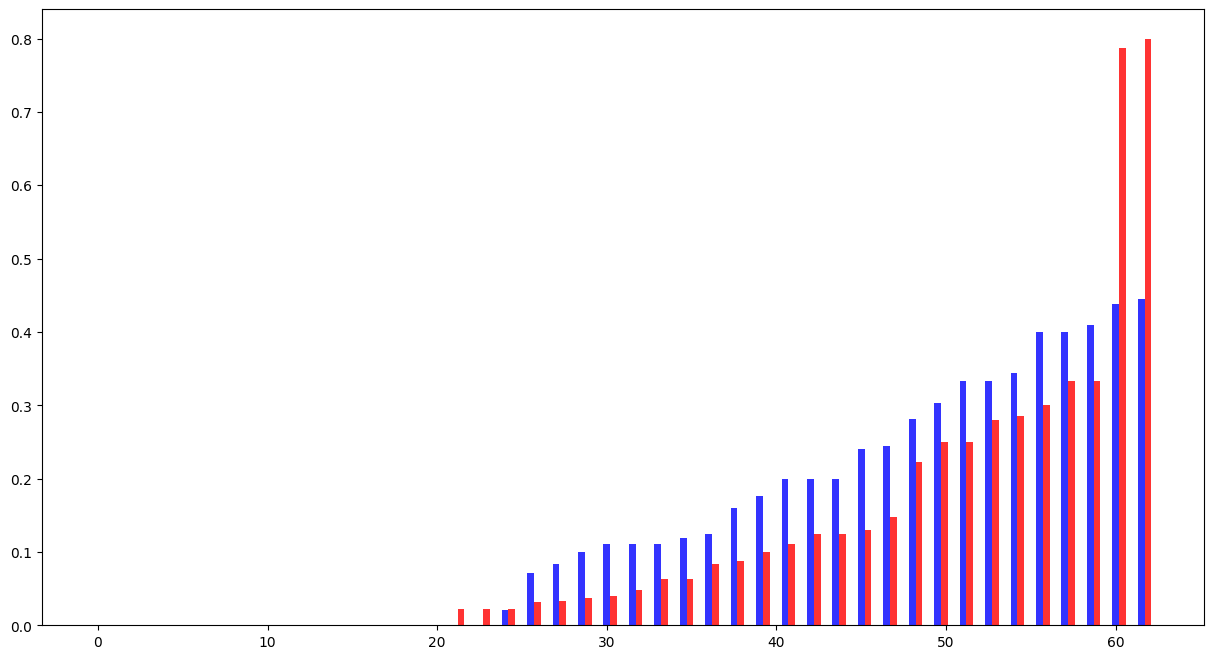

In [42]:
class_to_perc_incorrect_tree_llama, class_to_perc_incorrect_withouttree_llama = incorrect_per_class(llama_df)

In [43]:
class_to_perc_incorrect_tree_llama

{0: 0.0,
 10: 0.0,
 12: 0.0,
 14: 0.0,
 21: 0.0,
 23: 0.0,
 24: 0.0,
 26: 0.0,
 32: 0.0,
 34: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 13: 0.020833333333333332,
 15: 0.07142857142857142,
 28: 0.08333333333333333,
 6: 0.1,
 18: 0.1111111111111111,
 31: 0.1111111111111111,
 35: 0.1111111111111111,
 5: 0.11904761904761904,
 20: 0.125,
 1: 0.16,
 25: 0.17647058823529413,
 16: 0.2,
 17: 0.2,
 30: 0.2,
 2: 0.24,
 8: 0.24444444444444444,
 3: 0.28125,
 9: 0.30303030303030304,
 27: 0.3333333333333333,
 29: 0.3333333333333333,
 7: 0.34375,
 11: 0.4,
 19: 0.4,
 4: 0.4090909090909091,
 33: 0.4375,
 22: 0.4444444444444444}

Qwen VL-MAX

In [44]:
MODEL_QWEN = 'qwen-vl-max'
cursor, conn, qwen_df = load_db('Results/db/answers.db', MODEL_QWEN)
qwen_df

,Class,Sequence,Image_path,LLM_name,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,00000,Data/GTSRB/all_sequences_training\00000\00000_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",0,0,0
1,0,00001,Data/GTSRB/all_sequences_training\00000\00001_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",0,14,0
2,0,00002,Data/GTSRB/all_sequences_training\00000\00002_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",0,32,0
3,0,00003,Data/GTSRB/all_sequences_training\00000\00003_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",0,14,0
4,0,00004,Data/GTSRB/all_sequences_training\00000\00004_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",0,0,0
...,...,...,...,...,...,...,...,...
896,42,00001,Data/GTSRB/all_sequences_training\00042\00001_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",18,40,18
897,42,00002,Data/GTSRB/all_sequences_training\00042\00002_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",15,32,15
898,42,00003,Data/GTSRB/all_sequences_training\00042\00003_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",25,32,25
899,42,00004,Data/GTSRB/all_sequences_training\00042\00004_...,qwen-vl-max,"[{""question"": ""What's the sign's primary shape...",15,32,15


In [45]:
qwen_df = add_is_correct_col(qwen_df)

     Class  LLM_output_without_tree_class  without_tree_is_correct
0        0                              0                        1
1        0                              0                        1
2        0                              1                        0
3        0                              0                        1
4        0                              0                        1
..     ...                            ...                      ...
181     28                             28                        1
182     28                             28                        1
183     28                             28                        1
184     28                             28                        1
185     28                             28                        1

[901 rows x 3 columns]


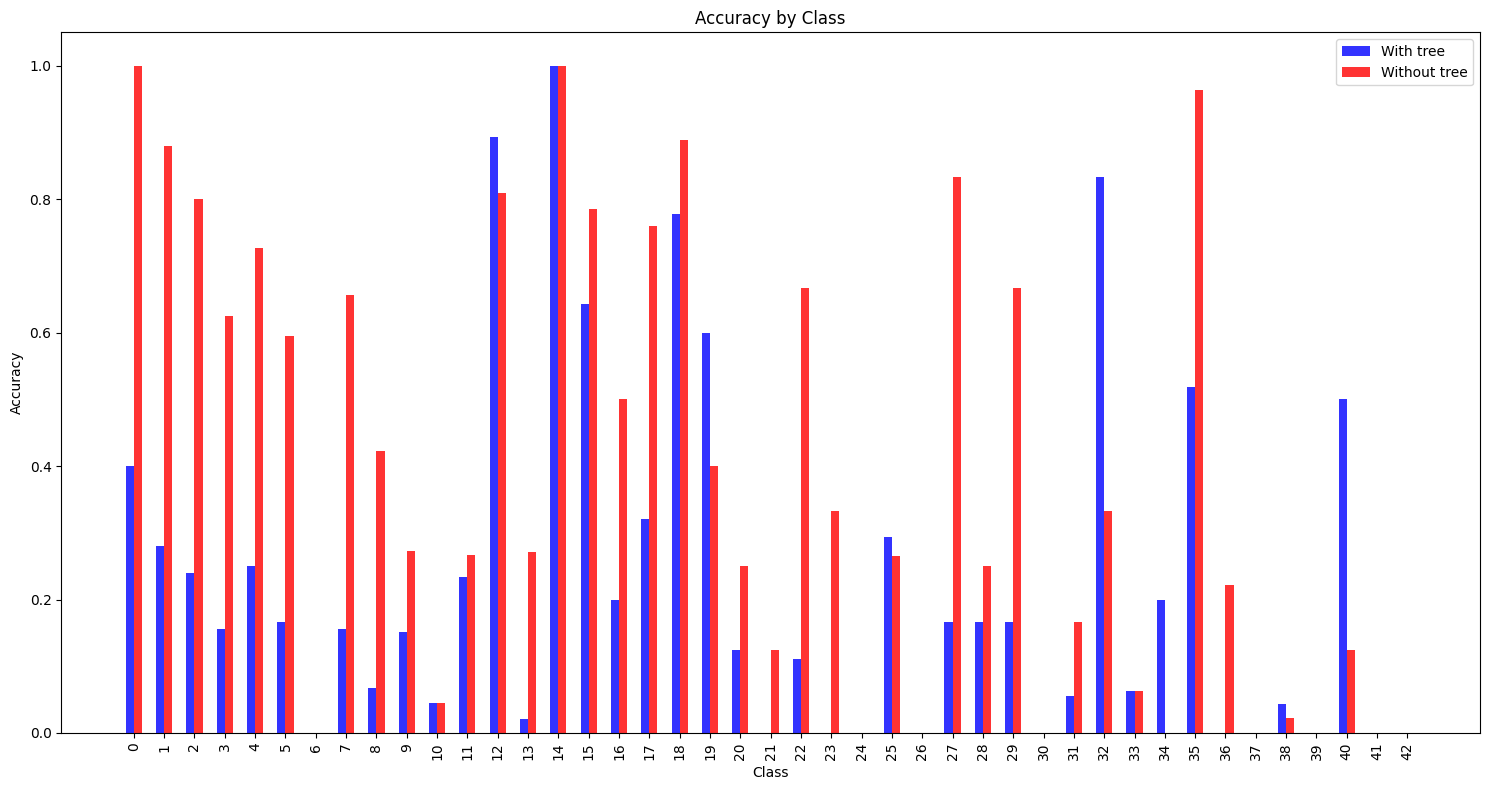

In [46]:
tree_is_correct_qwen, without_tree_is_correct_qwen = plot_comparison_accuracy(qwen_df)

In [49]:
accuracy_comparison_grouped(tree_is_correct_qwen, without_tree_is_correct_qwen)

Class 32 with tree outperform without tree by 50.0%
----------------------
Mean accuracy of model with tree:  0.22892618521669814
Mean accuracy of model without tree:  0.39506741332043527
----------------------
Class 27 without tree outperform with tree model by 66.66666666666667%
Class 0 without tree outperform with tree model by 60.0%
Class 1 without tree outperform with tree model by 60.0%
Class 2 without tree outperform with tree model by 56.00000000000001%
Class 22 without tree outperform with tree model by 55.55555555555556%
Class 7 without tree outperform with tree model by 50.0%
Class 29 without tree outperform with tree model by 50.0%
Class 4 without tree outperform with tree model by 47.72727272727273%
Class 3 without tree outperform with tree model by 46.875%
Class 35 without tree outperform with tree model by 44.44444444444444%
Class 17 without tree outperform with tree model by 44.0%
Class 5 without tree outperform with tree model by 42.85714285714286%


Number of samples where both models are correct:  188
Number of samples where both models are incorrect:  442
Number of samples where tree model is correct and the other is incorrect:  34
Number of samples where without tree model is correct and the other is incorrect:  237


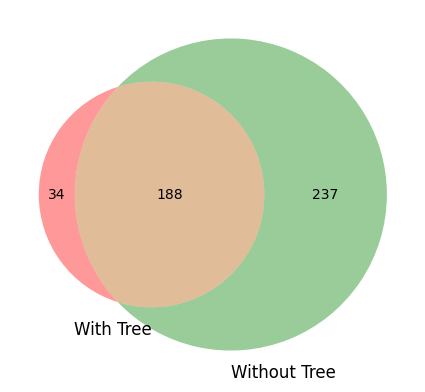

In [50]:
plot_venn_comparison(qwen_df)

Class 0:
Total: 5
Both correct: 2
Both incorrect: 0
Tree correct only: 0
Without tree correct only: 3
Tree incorrect only: 3
Without tree incorrect only: 0


Class 1:
Total: 50
Both correct: 14
Both incorrect: 6
Tree correct only: 0
Without tree correct only: 30
Tree incorrect only: 30
Without tree incorrect only: 0


Class 2:
Total: 50
Both correct: 10
Both incorrect: 8
Tree correct only: 2
Without tree correct only: 30
Tree incorrect only: 30
Without tree incorrect only: 2


Class 3:
Total: 32
Both correct: 5
Both incorrect: 12
Tree correct only: 0
Without tree correct only: 15
Tree incorrect only: 15
Without tree incorrect only: 0


Class 4:
Total: 44
Both correct: 10
Both incorrect: 11
Tree correct only: 1
Without tree correct only: 22
Tree incorrect only: 22
Without tree incorrect only: 1


Class 5:
Total: 42
Both correct: 7
Both incorrect: 17
Tree correct only: 0
Without tree correct only: 18
Tree incorrect only: 18
Without tree incorrect only: 0


Class 6:
Total: 10
Both correct

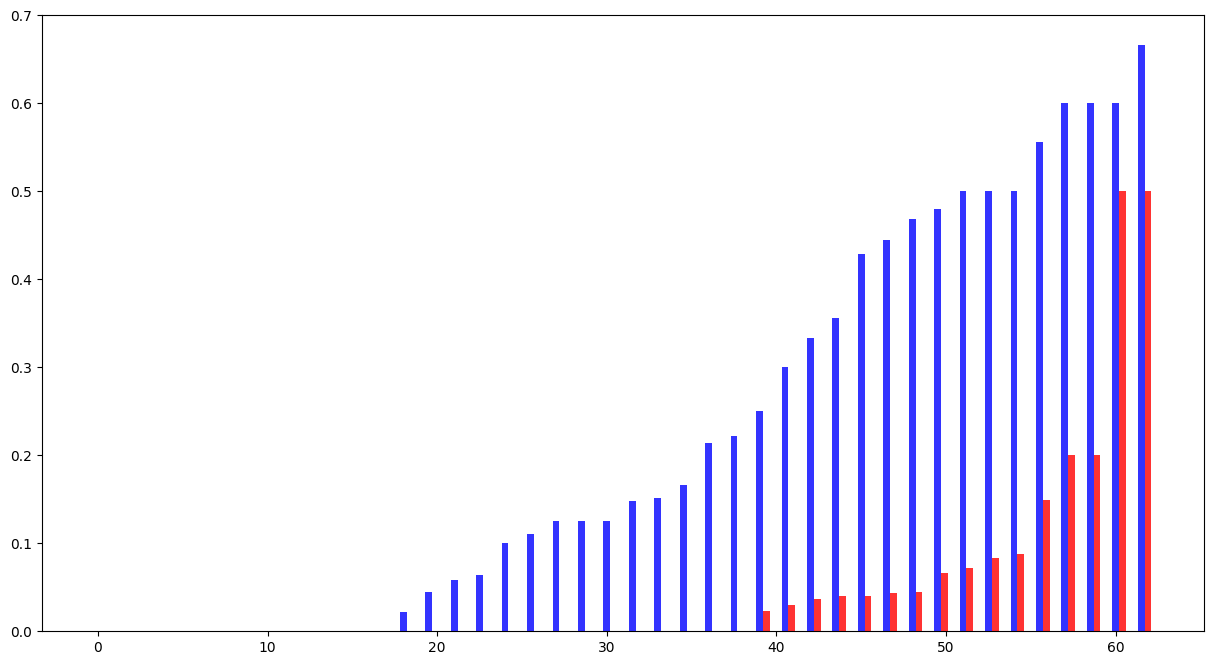

In [51]:
class_to_perc_incorrect_tree_qwen, class_to_perc_incorrect_withouttree_qwen = incorrect_per_class(qwen_df)

In [52]:
class_to_perc_incorrect_tree_qwen

{6: 0.0,
 14: 0.0,
 19: 0.0,
 24: 0.0,
 26: 0.0,
 30: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 37: 0.0,
 39: 0.0,
 41: 0.0,
 38: 0.021739130434782608,
 10: 0.044444444444444446,
 25: 0.058823529411764705,
 12: 0.06382978723404255,
 11: 0.1,
 31: 0.1111111111111111,
 20: 0.125,
 21: 0.125,
 40: 0.125,
 18: 0.14814814814814814,
 9: 0.15151515151515152,
 28: 0.16666666666666666,
 15: 0.21428571428571427,
 36: 0.2222222222222222,
 13: 0.25,
 16: 0.3,
 23: 0.3333333333333333,
 8: 0.35555555555555557,
 5: 0.42857142857142855,
 35: 0.4444444444444444,
 3: 0.46875,
 17: 0.48,
 4: 0.5,
 7: 0.5,
 29: 0.5,
 22: 0.5555555555555556,
 0: 0.6,
 1: 0.6,
 2: 0.6,
 27: 0.6666666666666666}

## CIFAR-10

In [9]:
MODEL_NAME = 'gpt-4o'
cursor, conn, gpt_df_cifar = load_db('Results/db/cifar10_answers.db', MODEL_NAME)
gpt_df_cifar

,Class,Sequence,Image_path,LLM_name,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,batch,batch_2_image_4958,gpt-4o,"[{""question"": ""Is the object in the image a li...",0,0,0
1,0,batch,batch_3_image_5814,gpt-4o,"[{""question"": ""Is the object in the image a li...",0,0,0
2,0,batch,batch_3_image_6522,gpt-4o,"[{""question"": ""Is the object in the image a li...",0,0,0
3,0,batch,batch_2_image_513,gpt-4o,"[{""question"": ""Is the object in the image a li...",0,6,0
4,0,batch,batch_1_image_7183,gpt-4o,"[{""question"": ""Is the object in the image a li...",0,0,0
...,...,...,...,...,...,...,...,...
995,9,b'\x05\x00\x00\x00',batch_5_image_267,gpt-4o,"[{""question"": ""Is the object in the image a li...",9,9,9
996,9,b'\x02\x00\x00\x00',batch_2_image_1399,gpt-4o,"[{""question"": ""Is the object in the image a li...",9,9,9
997,9,b'\x03\x00\x00\x00',batch_3_image_6218,gpt-4o,"[{""question"": ""Is the object in the image a li...",1,9,1
998,9,b'\x03\x00\x00\x00',batch_3_image_9924,gpt-4o,"[{""question"": ""Is the object in the image a li...",9,9,9


Replace the modified rows with the new rows with new tree structure.

In [12]:
gpt_df_cifar = add_is_correct_col(gpt_df_cifar)

     Class  LLM_output_without_tree_class  without_tree_is_correct
0        0                              0                        1
1        0                              0                        1
2        0                              0                        1
3        0                              0                        1
4        0                              0                        1
..     ...                            ...                      ...
995      9                              9                        1
996      9                              9                        1
997      9                              1                        0
998      9                              9                        1
999      9                              9                        1

[1000 rows x 3 columns]


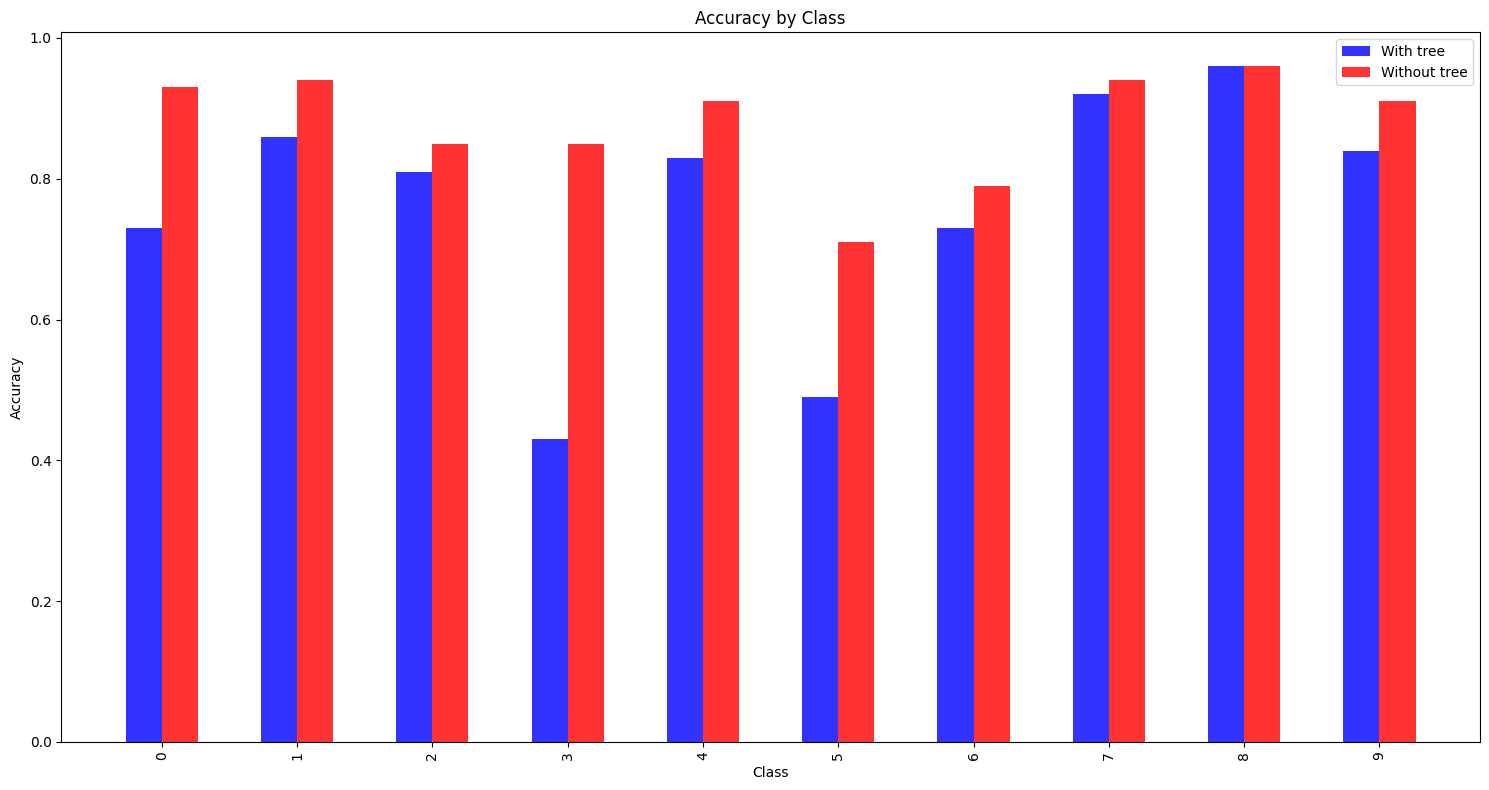

In [13]:
tree_is_correct, without_tree_is_correct = plot_comparison_accuracy(gpt_df_cifar)

In [14]:
accuracy_comparison_grouped(tree_is_correct, without_tree_is_correct)

----------------------
Mean accuracy of model with tree:  0.76
Mean accuracy of model without tree:  0.8789999999999999
----------------------
Class 3 without tree outperform with tree model by 42.0%


Number of samples where both models are correct:  726
Number of samples where both models are incorrect:  87
Number of samples where tree model is correct and the other is incorrect:  34
Number of samples where without tree model is correct and the other is incorrect:  153


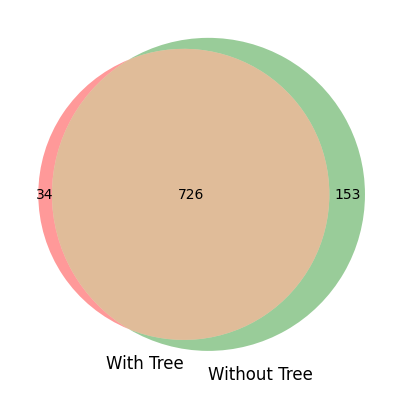

In [ ]:
plot_venn_comparison(gpt_df_cifar)

In [21]:
class_to_perc_incorrect_tree, class_to_perc_incorrect_withouttree = incorrect_per_class(gpt_df_cifar)

Class 0:
Total: 100
Both correct: 73
Both incorrect: 7
Tree correct only: 0
Without tree correct only: 20
Tree incorrect only: 20
Without tree incorrect only: 0


Class 1:
Total: 100
Both correct: 84
Both incorrect: 4
Tree correct only: 2
Without tree correct only: 10
Tree incorrect only: 10
Without tree incorrect only: 2


Class 2:
Total: 100
Both correct: 78
Both incorrect: 12
Tree correct only: 3
Without tree correct only: 7
Tree incorrect only: 7
Without tree incorrect only: 3


Class 3:
Total: 100
Both correct: 42
Both incorrect: 14
Tree correct only: 1
Without tree correct only: 43
Tree incorrect only: 43
Without tree incorrect only: 1


Class 4:
Total: 100
Both correct: 78
Both incorrect: 4
Tree correct only: 5
Without tree correct only: 13
Tree incorrect only: 13
Without tree incorrect only: 5


Class 5:
Total: 100
Both correct: 37
Both incorrect: 17
Tree correct only: 12
Without tree correct only: 34
Tree incorrect only: 34
Without tree incorrect only: 12


Class 6:
Total: 100

In [22]:
class_to_perc_incorrect_tree

{8: 0.02,
 7: 0.05,
 2: 0.07,
 6: 0.08,
 1: 0.1,
 9: 0.11,
 4: 0.13,
 0: 0.2,
 5: 0.34,
 3: 0.43}

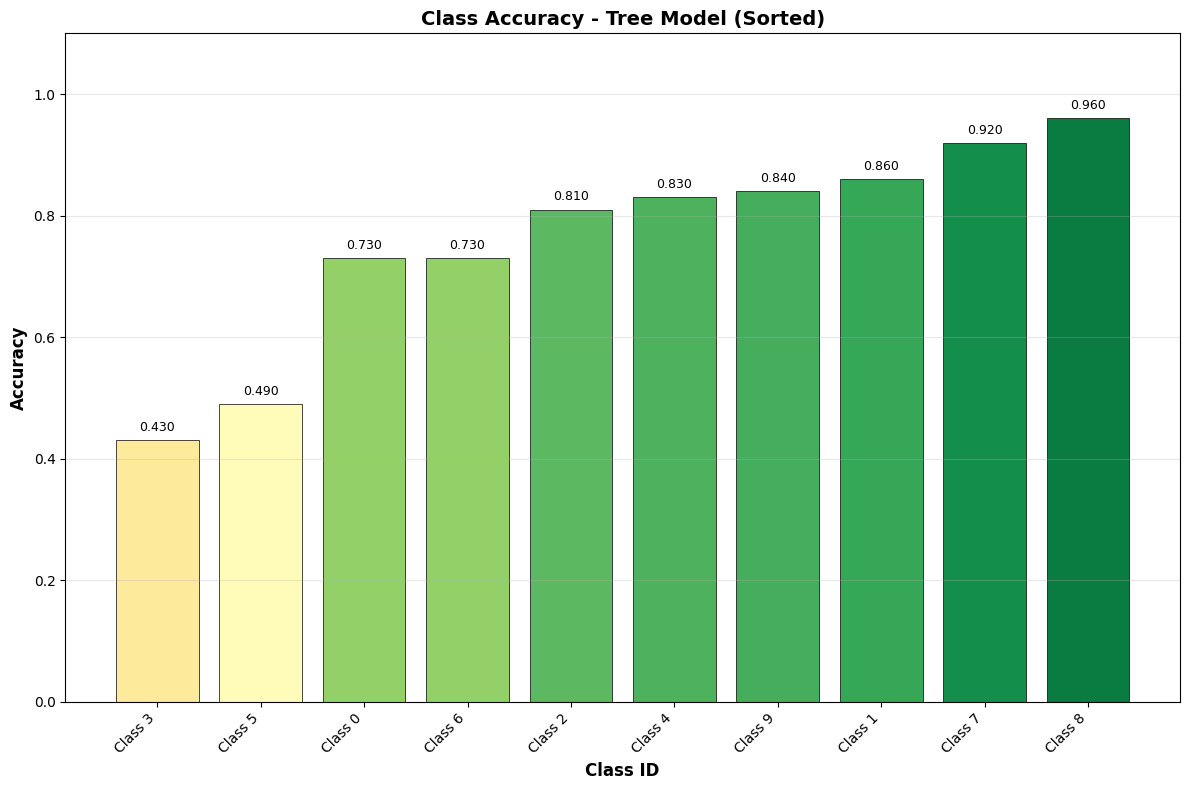

{0: 0.73,
 1: 0.86,
 2: 0.81,
 3: 0.43,
 4: 0.83,
 5: 0.49,
 6: 0.73,
 7: 0.92,
 8: 0.96,
 9: 0.84}

In [24]:
plot_single_model_accuracy(gpt_df_cifar, model_type='tree')

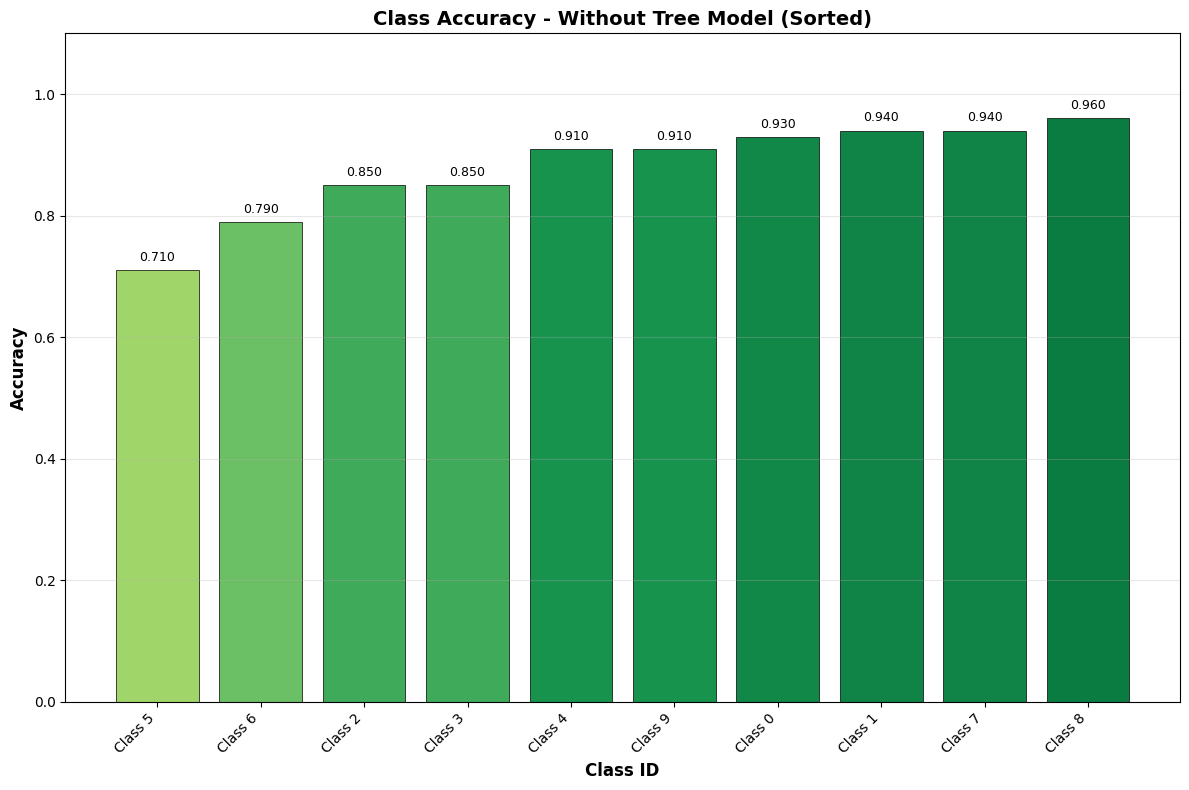

{0: 0.93,
 1: 0.94,
 2: 0.85,
 3: 0.85,
 4: 0.91,
 5: 0.71,
 6: 0.79,
 7: 0.94,
 8: 0.96,
 9: 0.91}

In [25]:
plot_single_model_accuracy(gpt_df_cifar, model_type='without_tree')

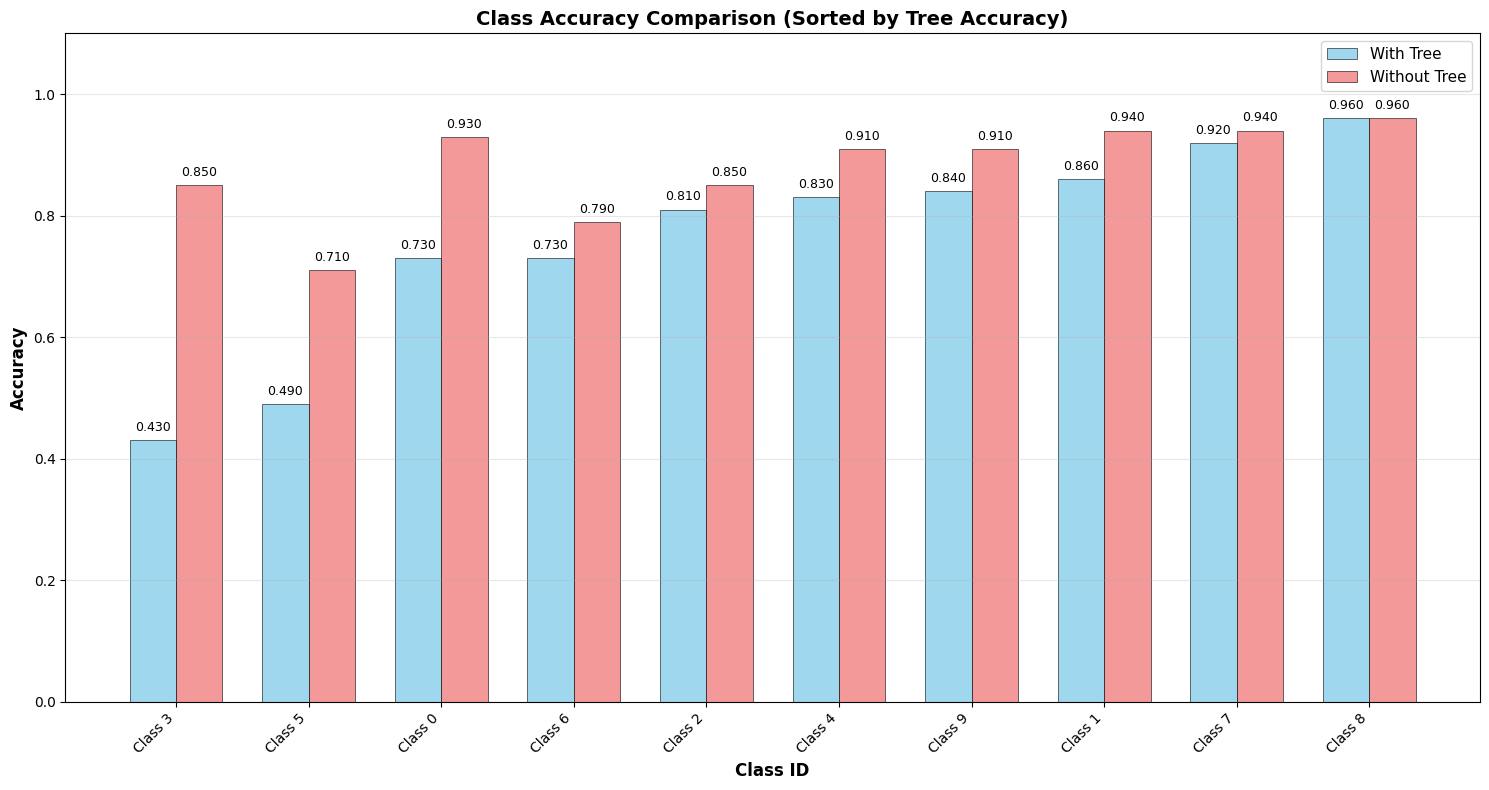

({0: 0.73,
  1: 0.86,
  2: 0.81,
  3: 0.43,
  4: 0.83,
  5: 0.49,
  6: 0.73,
  7: 0.92,
  8: 0.96,
  9: 0.84},
 {0: 0.93,
  1: 0.94,
  2: 0.85,
  3: 0.85,
  4: 0.91,
  5: 0.71,
  6: 0.79,
  7: 0.94,
  8: 0.96,
  9: 0.91})

In [23]:
plot_class_accuracy(gpt_df_cifar)

CIFAR-10 GPT4o (Including Memory)

In [25]:
MODEL_NAME = 'gpt-4o'
cursor, conn, gpt_df_cifar = load_db('Results/db/cifar10_answers.db', MODEL_NAME)
gpt_df_cifar

,Class,Sequence,Image_path,LLM_name,Include_memory,Include_description,Include_zero_shot_label,LLM_output_with_tree,LLM_output_without_tree,LLM_output_with_tree_class,LLM_output_without_tree_class
0,0,batch,batch_2_image_4958,gpt-4o,0,0,0,"[{""question"": ""Is the object in the image a li...",0,0,0
1,0,batch,batch_3_image_5814,gpt-4o,0,0,0,"[{""question"": ""Is the object in the image a li...",0,0,0
2,0,batch,batch_3_image_6522,gpt-4o,0,0,0,"[{""question"": ""Is the object in the image a li...",0,0,0
3,0,batch,batch_2_image_513,gpt-4o,0,0,0,"[{""question"": ""Is the object in the image a li...",0,6,0
4,0,batch,batch_1_image_7183,gpt-4o,0,0,0,"[{""question"": ""Is the object in the image a li...",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,3,5,batch_5_image_9692,gpt-4o,1,0,0,"[{""question"": ""Is the object in the image a li...",3,-1,3
1996,1,5,batch_5_image_9716,gpt-4o,1,0,0,"[{""question"": ""Is the object in the image a li...",1,1,1
1997,3,5,batch_5_image_9872,gpt-4o,1,0,0,"[{""question"": ""Is the object in the image a li...",3,3,3
1998,7,5,batch_5_image_9935,gpt-4o,1,0,0,"[{""question"": ""Is the object in the image a li...",7,7,7


In [26]:
gpt_df_cifar = add_is_correct_col(gpt_df_cifar)

      Class  LLM_output_without_tree_class  without_tree_is_correct
0         0                              0                        1
1         0                              0                        1
2         0                              0                        1
3         0                              0                        1
4         0                              0                        1
...     ...                            ...                      ...
1995      3                              3                        1
1996      1                              1                        1
1997      3                              3                        1
1998      7                              7                        1
1999      2                              2                        1

[2000 rows x 3 columns]


Filter the DataFrame to include only rows that Included the memory.

In [ ]:
def add_class_names(df):
    # add class names to the df
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
    df['Class_name'] = df['Class'].map(class_names)
    return df

In [31]:
# compare between the including memory and not including memory


def plot_comparison_accuracy_memory(df_1, df_2, label_1, label_2, class_names: dict):
    # df_1['tree_is_correct'] = df_1['tree_is_correct'].astype(int)
    # df_2['tree_is_correct'] = df_2['tree_is_correct'].astype(int)

    # Group by class and calculate mean accuracy
    tree_is_correct_1 = df_1.groupby('Class')['tree_is_correct'].mean()
    tree_is_correct_2 = df_2.groupby('Class')['tree_is_correct'].mean()

    # Sort by class index
    tree_is_correct_1 = tree_is_correct_1.sort_index()
    tree_is_correct_2 = tree_is_correct_2.sort_index()

    # add class names to the series (column 'Class_name' is already added in the DataFrame)
    tree_is_correct_1.index = tree_is_correct_1.index.map(lambda x: class_names.get(x))
    tree_is_correct_2.index = tree_is_correct_2.index.map(lambda x: class_names.get(x))

    # Bar chart
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.4
    opacity = 0.8

    # Increase space between columns by adjusting the index
    index = np.arange(len(tree_is_correct_1)) * 1.5  # Multiply by a factor to increase spacing

    # Plot bars
    rects1 = plt.bar(index, tree_is_correct_1, bar_width, alpha=opacity, color='b', label=label_1)
    rects2 = plt.bar(index + bar_width, tree_is_correct_2, bar_width, alpha=opacity, color='r', label=label_2)

    # Customize the plot
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Class')
    plt.xticks(index + bar_width / 2, tree_is_correct_1.index, rotation=90)  # Center ticks between bars
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    return tree_is_correct_1, tree_is_correct_2

Number of samples with memory: 1000
Number of samples without memory: 1000


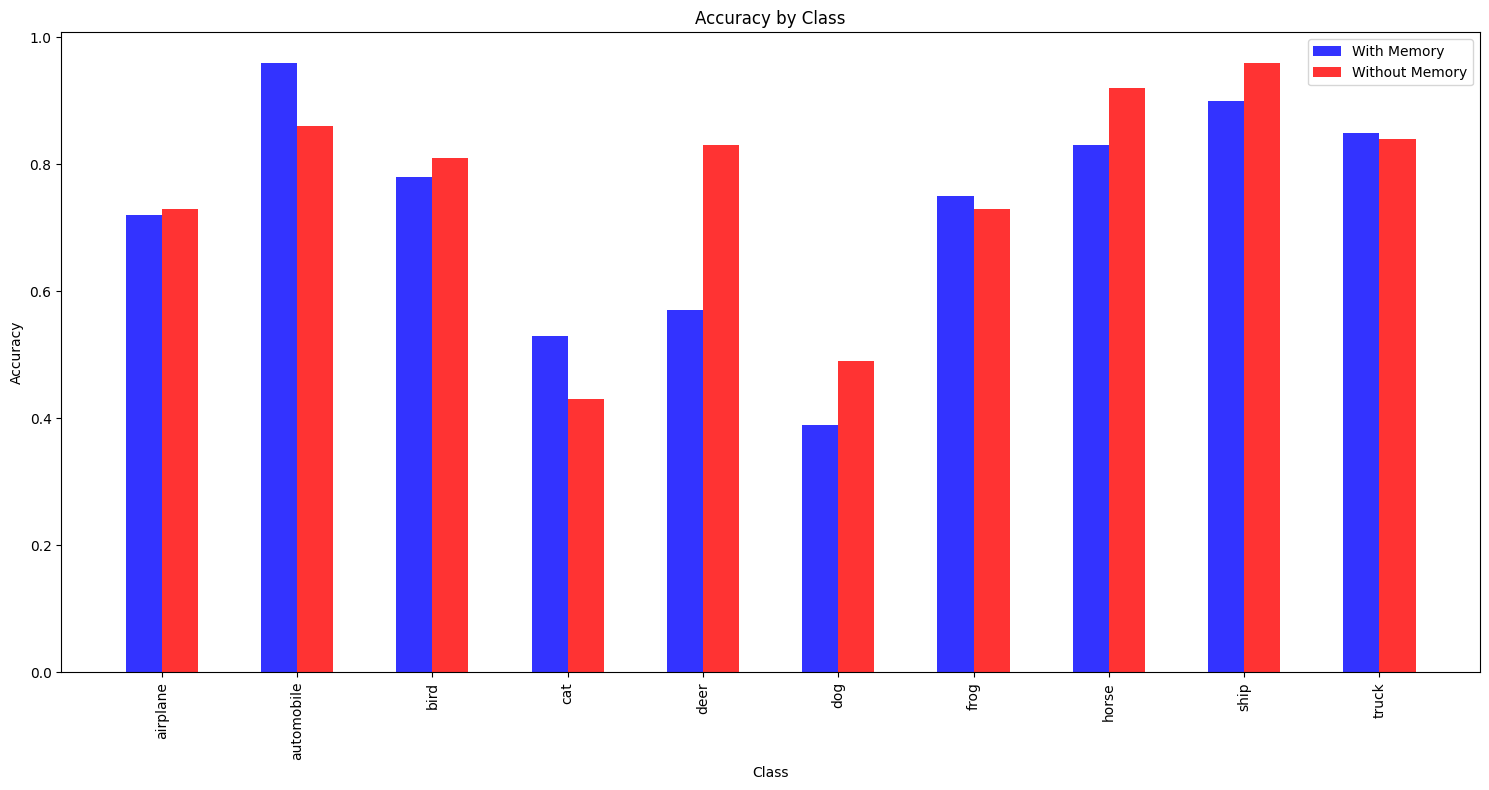

In [34]:
gpt_df_cifar_memory = gpt_df_cifar[gpt_df_cifar['Include_memory'] == 1]
gpt_df_cifar_no_memory = gpt_df_cifar[gpt_df_cifar['Include_memory'] == 0]
print(f"Number of samples with memory: {len(gpt_df_cifar_memory)}")
print(f"Number of samples without memory: {len(gpt_df_cifar_no_memory)}")
class_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
tree_is_correct_with_memory, tree_is_correct_without_memory = plot_comparison_accuracy_memory(gpt_df_cifar_memory, gpt_df_cifar_no_memory, 'With Memory', 'Without Memory', class_names)

In [41]:
# plot the difference in accuracy
def plot_accuracy_difference(tree_is_correct_with_memory, tree_is_correct_without_memory):
    # Calculate the difference in accuracy
    accuracy_diff = tree_is_correct_with_memory - tree_is_correct_without_memory

    # Sort by class index
    accuracy_diff = accuracy_diff.sort_index()

    # Create a bar chart for the difference
    fig, ax = plt.subplots(figsize=(15, 8))
    bar_width = 0.4
    opacity = 0.8

    index = np.arange(len(accuracy_diff)) * 1.5  # Increase spacing between bars

    rects = plt.bar(index, accuracy_diff, bar_width, alpha=opacity, color='g', label='Accuracy Difference')

    plt.xlabel('Class')
    plt.ylabel('Accuracy Difference')
    plt.title('Accuracy Difference by Class (With Memory - Without Memory)')
    plt.xticks(index + bar_width / 2, accuracy_diff.index, rotation=90)  # Center ticks between bars
    plt.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

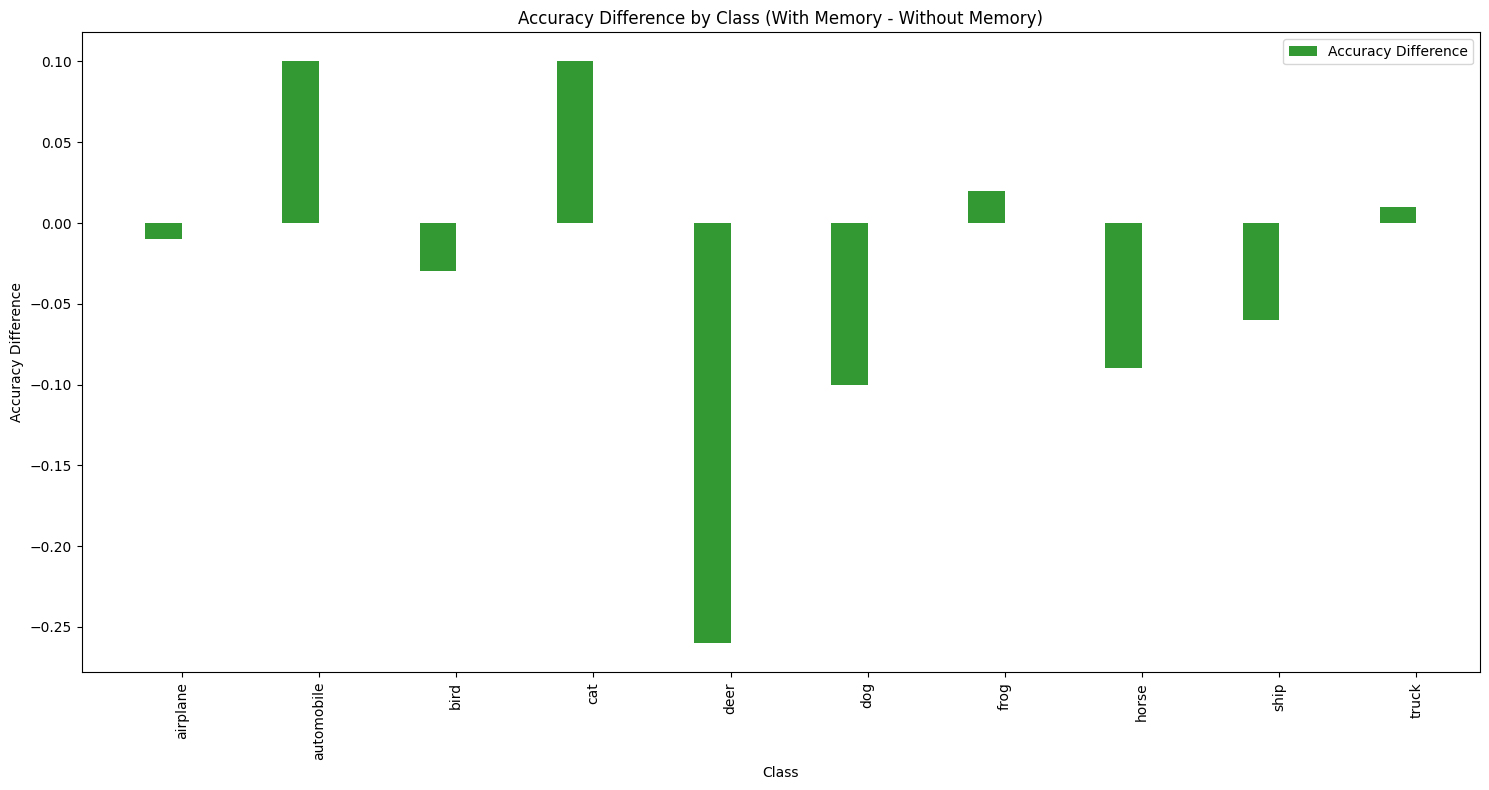

Mean accuracy with memory:  0.728
Mean accuracy without memory:  0.76
Mean accuracy difference:  Class
airplane     -0.01
automobile    0.10
bird         -0.03
cat           0.10
deer         -0.26
dog          -0.10
frog          0.02
horse        -0.09
ship         -0.06
truck         0.01
Name: tree_is_correct, dtype: float64


In [43]:
plot_accuracy_difference(tree_is_correct_with_memory, tree_is_correct_without_memory)
print("Mean accuracy with memory: ", tree_is_correct_with_memory.mean())
print("Mean accuracy without memory: ", tree_is_correct_without_memory.mean())
print("Mean accuracy difference: ", (tree_is_correct_with_memory - tree_is_correct_without_memory))